# Домашнее задание 5
В этом задании мы:

1. Построим U-Net для датасета VOC segmentation, посмотрим на качество семантической сегментации.
2. Соберем GAN для генерации картинок из MNIST.
3. Прикрутим к этому GAN обуславливание на метку класса, посмотрим на результат.

## U-Net на датасете VOC

Датасет [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) - один из классических датасетов для задачи семантической сегментации.
Его используют в статьях и [по сей день](https://paperswithcode.com/dataset/pascal-voc) для бенчмарков.

В этом задании вам нужно скачать этот датасет, разбить на train и validation части, и обучить на нем U-Net.
Код для U-Net разбирался в семинаре.

В ЛМС необходимо сдать вашу реализацию U-Net и `model.pt` файл обученной модели.
Чтобы сдать это задание, модель должна достигать accuracy > 50% на тестовом датасете.

In [1]:
import typing as tp
from functools import reduce
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from albumentations.pytorch.transforms import ToTensorV2
from IPython.display import clear_output, display
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation

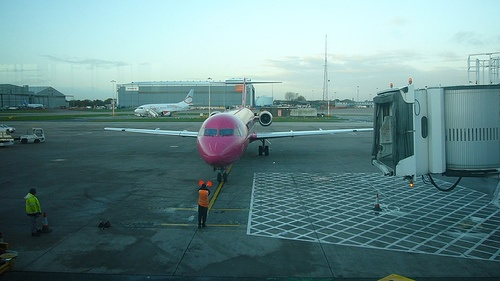

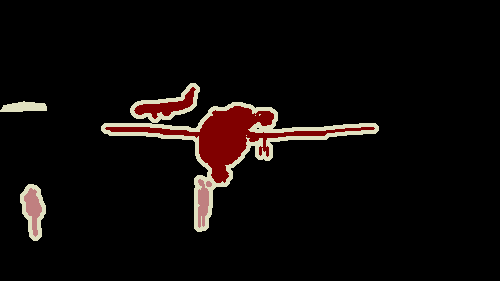

In [2]:
# Для начала загрузим датасет и посмотрим на его структуру
dataset = VOCSegmentation(
    root="./data",
    year="2012",
    image_set="train",
    download=not Path("./data").exists(),
)
display(dataset[0][0])
display(dataset[0][1])

In [13]:
dataset[0][1].size

(500, 281)

В датасете маске присваивается 255 для границы объекта, а внутри объекта присваивается число от 0 до 20 - метка класса.

In [3]:
# Пройдемся по всем маскам датасета и возьмем уникальные значения в пикселях
reduce(
    lambda s1, s2: s1.union(s2),
    (set(np.unique(np.array(dataset[i][1])).tolist()) for i in range(len(dataset))),
    set(),
)
# Ага, действительно, метки классов от 0 до 20, при этом 0 означает "ничего интересного нет", а 255 означает границу

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 255}

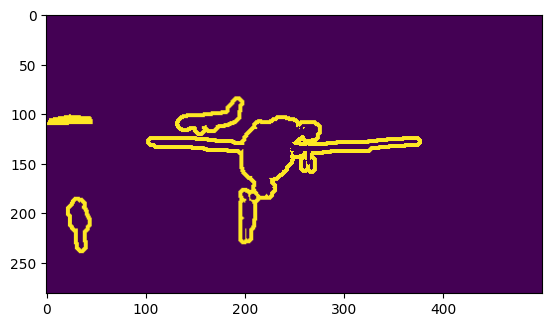

In [4]:
# Отрисуем только пиксели со значением 255 и убедимся, что они соответствуют границам объектов
plt.imshow(np.where(np.array(dataset[0][1]) == 255, 1, 0))

/root/nlp/.venv/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1803: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


(tensor([[[0.5137, 0.5137, 0.5216,  ..., 0.7176, 0.7137, 0.7137],
         [0.5176, 0.5176, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         [0.5216, 0.5216, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         ...,
         [0.0392, 0.0314, 0.0431,  ..., 0.0235, 0.0353, 0.0314],
         [0.0235, 0.0196, 0.0353,  ..., 0.0549, 0.0588, 0.0627],
         [0.0196, 0.0353, 0.0431,  ..., 0.0667, 0.0588, 0.0667]],

        [[0.7569, 0.7569, 0.7647,  ..., 0.9137, 0.9098, 0.9098],
         [0.7608, 0.7608, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         [0.7647, 0.7647, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         ...,
         [0.0627, 0.0549, 0.0588,  ..., 0.0980, 0.1059, 0.1059],
         [0.0588, 0.0549, 0.0549,  ..., 0.1294, 0.1294, 0.1333],
         [0.0549, 0.0706, 0.0627,  ..., 0.1412, 0.1294, 0.1373]],

        [[0.8157, 0.8157, 0.8235,  ..., 0.9412, 0.9451, 0.9451],
         [0.8196, 0.8196, 0.8275,  ..., 0.9451, 0.9490, 0.9490],
         [0.8235, 0.8235, 0.8275,  ..., 0.9451, 0.9490, 0

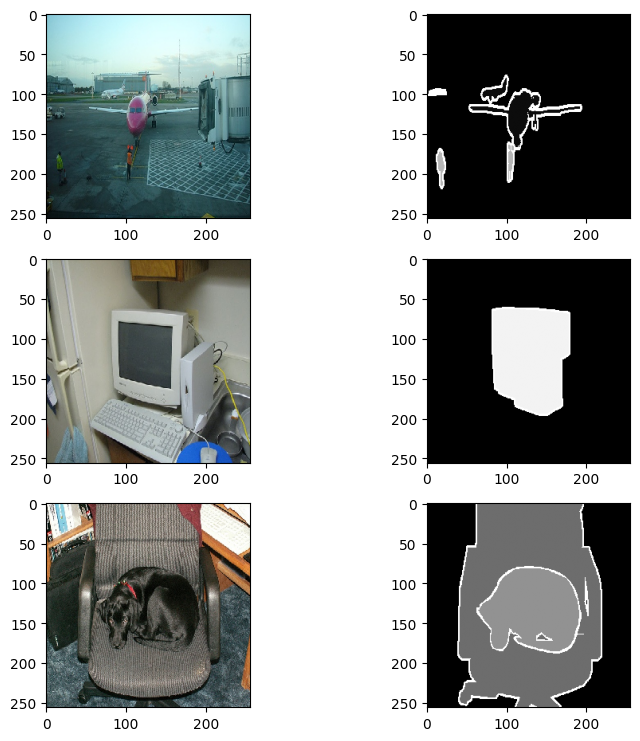

In [5]:
n_classes, img_size = 22, 256


def load_voc_dataset(split: tp.Literal["train", "val", "test"]):
    transforms = A.Compose(
        [
            A.Resize(img_size, img_size, interpolation=cv2.INTER_NEAREST),
            A.Lambda(
                image=lambda image, **_: (image / 255.0).astype(np.float32),
                mask=lambda mask, **_: np.where(mask == 255, 21, mask).astype(np.int64),
            ),
            ToTensorV2(),
        ]
    )

    def _transform(image, mask):
        # Конвертируем из PIL формата в np.array за счет np.array(image).
        # Заметьте, image=..., mask=... - это указание, что есть изображение и что есть маска.
        # Albumentations в общем виде по-разному обрабатывает изображения и маски.
        transformed = transforms(image=np.array(image), mask=np.array(mask))
        return transformed["image"], transformed["mask"]

    # Создание датасета с нужными трансформациями
    dataset = VOCSegmentation(
        root="./data",
        year="2012",
        image_set=split,
        download=not Path("./data").exists(),
        transforms=_transform,
    )
    return dataset


train_dataset = load_voc_dataset("train")
val_dataset = load_voc_dataset("val")
print(train_dataset[0])
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

# Отрисовка изображения и маски
fig, ax = plt.subplots(3, 2, figsize=(9, 9))
for i in range(3):
    img, mask = train_dataset[i]
    ax[i][0].imshow(img.permute(1, 2, 0).numpy())
    ax[i][1].imshow(mask.numpy(), cmap="gray")
fig.show();

In [48]:
img, mask = train_dataset[0]
print(img.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256])


Теперь очередь за вами.
Обучите модель и сдайте её в ЛМС (инструкции выше).

Обратите внимание, что границы объекта выделены пикселем 255 - это немного выбивается из остальных классов, где метки идут с шагом 1 (0, 1, 2 и т.д. до 21).
Подумайте, как это исправить.

In [7]:
seed = 0
batch_size = 20
n_steps_before_backward = 8

In [8]:
import os
import random


def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)


def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)


enable_determinism()
fix_seeds(seed)

In [9]:
import wandb
wandb.login(key='cc603ae0565bbbfce5cc5b068a9bddabb8950920')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: theotheo46 (theotheo46-trs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
from torch.utils.data import DataLoader, random_split

generator = torch.Generator().manual_seed(seed)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, generator=generator
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
from functools import reduce

import torch.nn as nn
import torch.nn.functional as F
import tqdm
import wandb
from torch.optim import Adam


def calc_accuracy(model: nn.Module, loader: DataLoader, device: torch.device):
    count_correct, count_total = 0, 0
    model.eval()
    for img_batch, true_labels in loader:
        img_batch = img_batch.to(device)
        true_labels = true_labels.to(device)
        with torch.no_grad():
            prediction = model(img_batch)
        # (B, K, H, W)
        # pred_labels = (prediction > 0).squeeze(1)
        pred_labels = torch.argmax(prediction, dim=1)
        count_correct += (pred_labels == true_labels).sum().item()
        # произведение всех размерностей
        count_total += reduce(lambda a, b: a * b, true_labels.shape, 1)
    model.train()
    return count_correct / count_total


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    lr = 1e-3
    n_epochs = 10
    eval_every = 20
    optimizer = Adam(model.parameters(), lr=lr)
    model.to(device)
    criterion = nn.CrossEntropyLoss(reduction="none")

    for epoch in range(n_epochs):
        print(f"Epoch #{epoch + 1}/#{n_epochs}")
        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            optimizer.zero_grad()
            step = epoch * len(train_loader) + i
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)

            pred_labels = model(img_batch).squeeze()
            loss = criterion(pred_labels, true_labels.long()).mean()
            loss.backward()

            # Будем не каждую итерацию делать шаг спуска.
            # Это увеличит batch_size без необходимости вмещать больше в память.
            if (step + 1) % n_steps_before_backward == 0:
                optimizer.step()

            wandb.log({"loss": loss.cpu().item()}, step=step)
            if (i + 1) % eval_every == 0:
                wandb.log(
                    {"accuracy": calc_accuracy(model, val_loader, device)}, step=step
                )
        wandb.log({"accuracy": calc_accuracy(model, val_loader, device)}, step=step)
    wandb.finish()

In [53]:
class SimpleModel(nn.Module):
    def __init__(self, n_channels: int, n_classes: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(n_channels, hidden_dim, 3),
            nn.ConvTranspose2d(hidden_dim, n_classes, 3),
        )

    def forward(self, x):
        return self.net(x)


model = SimpleModel(n_channels=3, n_classes=n_classes)
model(next(iter(val_loader))[0]).shape

torch.Size([4, 22, 256, 256])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
wandb.init(project="start-dl-lesson-5_3", name="Unet")
train_loop(model, train_loader, val_loader, device=device)

Epoch #1/#10


100%|██████████| 74/74 [01:42<00:00,  1.39s/it]


Epoch #2/#10


100%|██████████| 74/74 [01:45<00:00,  1.43s/it]


Epoch #3/#10


100%|██████████| 74/74 [01:42<00:00,  1.38s/it]


Epoch #4/#10


100%|██████████| 74/74 [01:45<00:00,  1.43s/it]


Epoch #5/#10


100%|██████████| 74/74 [01:41<00:00,  1.38s/it]


Epoch #6/#10


100%|██████████| 74/74 [01:46<00:00,  1.44s/it]


Epoch #7/#10


100%|██████████| 74/74 [01:41<00:00,  1.37s/it]


Epoch #8/#10


100%|██████████| 74/74 [01:46<00:00,  1.44s/it]


Epoch #9/#10


100%|██████████| 74/74 [01:40<00:00,  1.36s/it]


Epoch #10/#10


100%|██████████| 74/74 [01:45<00:00,  1.43s/it]


accuracy,▄▁▁▃▅▆▆▆▆▇▇▇▇▇██████████████████████████
loss,█▇▆▆▆▅▅▄▅▄▄▄▄▄▃▄▄▃▃▃▂▃▃▂▂▂▂▂▂▃▁▁▂▂▂▁▂▂▁▃
accuracy,0.68885
loss,1.83091


In [15]:
# Имплементация U-Net, взято из https://github.com/milesial/Pytorch-UNet
# Распространяется под лицензией GPL-3.0
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x: torch.Tensor, x_left: torch.Tensor):
        x = self.up(x)
        # Западдим картинку снизу, если размерности отличаются
        diffY = x_left.shape[2] - x.shape[2]
        diffX = x_left.shape[3] - x.shape[3]

        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x_left, x], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [18]:
model = UNet(3, n_classes)
model(next(iter(val_loader))[0]).shape

torch.Size([20, 22, 256, 256])

In [20]:

torch.save(model.state_dict(), "model.pt")

## GAN на MNIST

Во второй части задания мы попробуем генерировать изображения с цифрами.
Для этого возьмем модель GAN и обучим ее на датасет MNIST.

Ваша задача: скачайте датасет MNIST, обучите на нем GAN, сохраните веса генератора и дискриминатора в `generator.pt` и `discriminator.pt` соответственно.
Сдайте в ЛМС:
1. Код генератора и его веса.
2. Код дискриминатора и его веса.

In [7]:
# Используйте следующие параметры модели
image_size = 28
# Размер латентного вектора - из него генератор будет создавать изображение
nz = 100

## GAN с условиями

Наш GAN генерирует картинку из случайного класса.
Однако можно научить его принимать на вход метку класса и генерировать картинку с этой меткой.
Такие GAN называются **Conditional GAN** (*обусловленный GAN*).

Добавить обуславливание достаточно просто:
1. Добавьте в генератор embedding-слой для метки класса. Берите небольшую размерность вектора, 10-ти хватит.
2. Поменяйте первый ConvTranspose2d так, чтобы тот принял вектор длины 110 (100 от рандома, 10 от эмбеддинга).
3. Поменяйте код `forward` так, чтобы в ConvTranspose2d передавать объединенный вектор размера 110.
4. Сделайте аналогичные изменения в `Discriminator` - он тоже должен принимать `label` как аргумент в `forward` и учитывать его. Подумайте, какие слои и как надо будет поменять.

Сделайте **Conditional GAN**, обучите его.
Сдайте в ЛМС:
1. Новый код `Generator` и его веса.
2. Новый код `Discriminator` и его веса.

Если вы все сделали правильно, у вас должны получиться правдоподобные картинки для каждого из классов.